# TSNN examples

## Summary

- In narrow format, both lin reg and fully connected manage to capture a linear effect between features and target. A linear regression will always be better in this case since this is constrained to be exactly the function of the ground truth


In [205]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
import torch
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
import importlib
import sys
sys.path.append('/Users/cyrilgarcia/notebooks/tsnn/')

import tsnn

from tsnn.generators import generators
from tsnn.benchmarks import benchmark_comparison, ml_benchmarks, torch_benchmarks
from tsnn import utils
from tsnn.tstorch import transformers
import torch.nn.functional as F
import math
from typing import Optional

from torch import nn
device = 'mps'


plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [206]:
from dataclasses import dataclass

@dataclass
class Config:
    T: int = 3000
    n_ts: int = 5
    n_f: int = 10
    pct_zero_corr: float = 0.5
    split_conditional: float = 0.2
    split_shift: float = 0.2
    split_seasonal: float = 0.0
    split_cs: float = 0.2
    split_cs_shift: float = 0.2
    low_corr: float = 0.05
    high_corr: float = 0.1

In [207]:
z = generators.Generator(Config.T, Config.n_ts, Config.n_f)

In [208]:
%%time
z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)

CPU times: user 4.93 ms, sys: 7.11 ms, total: 12 ms
Wall time: 31.4 ms


In [209]:
z.get_dataloader()

### Simple benchmarks

In [210]:
# lasso benchmark
lasso = ml_benchmarks.LassoBenchmark()
lasso.fit(z.train)

In [211]:
lasso.score(z.train)

np.float64(0.12558286112926884)

In [212]:
# any custom benchmark
from sklearn.linear_model import LinearRegression
lr = ml_benchmarks.CustomBenchmark(LinearRegression())
lr.fit(z.train)

In [213]:
comp = benchmark_comparison.Comparator(models=[lasso, lr], model_names=['lasso', 'lr'])

In [214]:
comp.correl(z, mode='train')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso
optimal,0.164,nan,nan,nan,nan,nan,nan,nan
linear,0.089,0.509,nan,nan,nan,nan,nan,nan
conditional,0.061,0.423,0.031,nan,nan,nan,nan,nan
shift,0.078,0.468,0.004,-0.009,nan,nan,nan,nan
cs,0.067,0.454,0.009,0.013,0.004,nan,nan,nan
cs_shift,0.078,0.429,0.036,0.013,0.010,0.007,nan,nan
lasso,0.126,0.370,0.716,0.027,0.013,0.007,0.023,nan
lr,0.126,0.368,0.711,0.027,0.013,0.007,0.023,1.000


In [215]:
comp.correl(z, mode='test')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso
optimal,0.154,nan,nan,nan,nan,nan,nan,nan
linear,0.088,0.485,nan,nan,nan,nan,nan,nan
conditional,0.043,0.391,-0.027,nan,nan,nan,nan,nan
shift,0.063,0.471,-0.000,-0.023,nan,nan,nan,nan
cs,0.067,0.466,0.018,0.004,0.009,nan,nan,nan
cs_shift,0.084,0.431,0.009,0.026,0.011,0.006,nan,nan
lasso,0.107,0.346,0.714,-0.021,0.005,0.006,0.010,nan
lr,0.106,0.343,0.708,-0.021,0.005,0.006,0.010,1.000


## Torch benchmarks - narrow matrix (no cross-TS interactions)

### Fully connected

Equivalent to linear regression setup

In [216]:
z.get_dataloader(narrow=True)

In [217]:
from torch import nn
device = 'mps'

class NeuralNetwork(nn.Module):
    def __init__(self, n_f):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_f, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )
        
        self.linear_relu_stack = nn.Sequential(nn.Linear(n_f, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
                                              )
        
        
        
    def forward(self, x):
        pred = self.linear_relu_stack(x)
        return pred

In [220]:
m = NeuralNetwork(n_f=Config.n_f).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)


full_nn = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.94it/s]


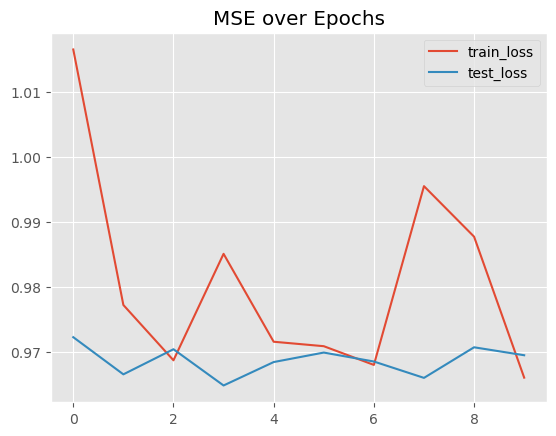

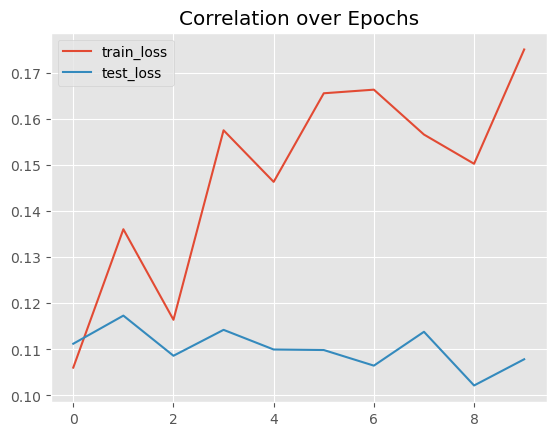

In [221]:
full_nn.fit(z.train, z.test, epochs=10)

In [222]:
comp = benchmark_comparison.Comparator(models=[full_nn, lasso], model_names=['nn', 'lasso'])

In [223]:
comp.correl(z, mode='train')

,true,optimal,linear,conditional,shift,cs,cs_shift,nn
optimal,0.164,nan,nan,nan,nan,nan,nan,nan
linear,0.089,0.509,nan,nan,nan,nan,nan,nan
conditional,0.061,0.423,0.031,nan,nan,nan,nan,nan
shift,0.078,0.468,0.004,-0.009,nan,nan,nan,nan
cs,0.067,0.454,0.009,0.013,0.004,nan,nan,nan
cs_shift,0.078,0.429,0.036,0.013,0.010,0.007,nan,nan
nn,0.205,0.366,0.538,0.227,0.014,0.012,0.017,nan
lasso,0.126,0.370,0.716,0.027,0.013,0.007,0.023,0.773


In [224]:
comp.correl(z, mode='test')

,true,optimal,linear,conditional,shift,cs,cs_shift,nn
optimal,0.154,nan,nan,nan,nan,nan,nan,nan
linear,0.088,0.485,nan,nan,nan,nan,nan,nan
conditional,0.043,0.391,-0.027,nan,nan,nan,nan,nan
shift,0.063,0.471,-0.000,-0.023,nan,nan,nan,nan
cs,0.067,0.466,0.018,0.004,0.009,nan,nan,nan
cs_shift,0.084,0.431,0.009,0.026,0.011,0.006,nan,nan
nn,0.107,0.345,0.526,0.208,0.006,-0.013,0.025,nan
lasso,0.107,0.346,0.714,-0.021,0.005,0.006,0.010,0.769


### LSTM

Equivalent to linear regression setup

In [225]:
z.get_dataloader(n_rolling=5, narrow=True, train_test_split=True, shuffle=False)

In [226]:
from torch import nn
device = 'mps'

class LSTMModel(nn.Module):
    def __init__(self, n_f, hidden_dim=32):
        super().__init__()
        self.encoder = nn.LSTM(input_size=n_f, hidden_size=hidden_dim, batch_first=True, num_layers=2)
        self.decoder = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        # x: (batch, T=10, n_f)
        _, (h, _) = self.encoder(x)
        out = self.decoder(h[-1]) 
        return out

In [227]:
m = LSTMModel(n_f=Config.n_f).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_lstm = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.43it/s]


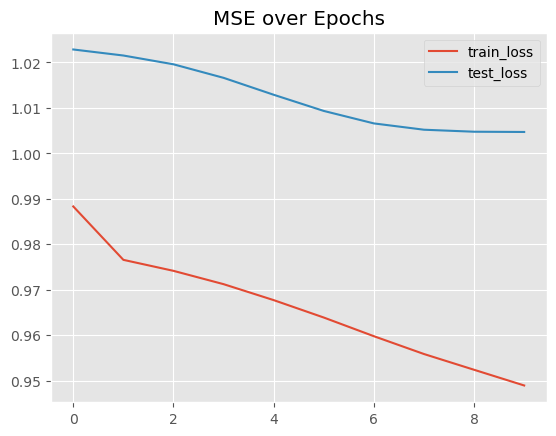

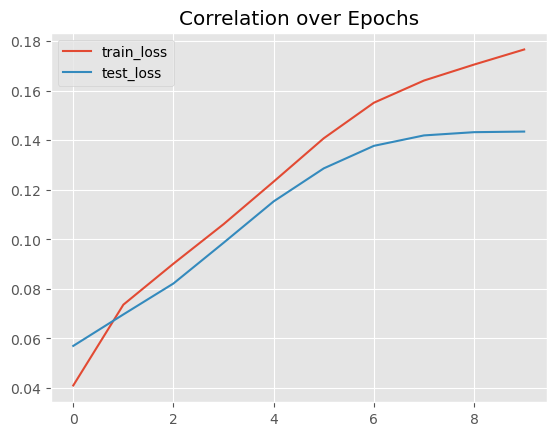

In [228]:
model_lstm.fit(z.train, test=z.test, epochs=10)

In [229]:
comp = benchmark_comparison.Comparator(models=[model_lstm, lasso], model_names=['lstm', 'lasso'])

In [230]:
comp.correl(z, mode='train')

,true,optimal,linear,conditional,shift,cs,cs_shift,lstm
optimal,0.164,nan,nan,nan,nan,nan,nan,nan
linear,0.095,0.500,nan,nan,nan,nan,nan,nan
conditional,0.056,0.417,0.013,nan,nan,nan,nan,nan
shift,0.065,0.472,0.005,-0.011,nan,nan,nan,nan
cs,0.073,0.463,0.012,0.018,0.009,nan,nan,nan
cs_shift,0.085,0.431,0.025,0.019,0.014,0.014,nan,nan
lstm,0.169,0.507,0.594,0.088,0.373,0.008,0.028,nan
lasso,0.121,0.360,0.713,0.019,0.004,0.004,0.022,0.828


In [231]:
comp.correl(z, mode='test')

,true,optimal,linear,conditional,shift,cs,cs_shift,lstm
optimal,0.154,nan,nan,nan,nan,nan,nan,nan
linear,0.075,0.507,nan,nan,nan,nan,nan,nan
conditional,0.053,0.407,0.016,nan,nan,nan,nan,nan
shift,0.093,0.462,-0.002,-0.017,nan,nan,nan,nan
cs,0.054,0.444,0.010,-0.009,-0.002,nan,nan,nan
cs_shift,0.069,0.427,0.034,0.014,0.002,-0.009,nan,nan
lstm,0.140,0.498,0.588,0.056,0.391,0.006,0.011,nan
lasso,0.119,0.370,0.722,-0.002,0.025,0.012,0.014,0.829


### Transformer

In [232]:
z.get_dataloader(n_rolling=5, narrow=True, train_test_split=True, shuffle=False)

In [233]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, n_f, n_rolling, d_model=64, nhead=4, num_layers=1, dropout=0.5):
        super().__init__()
        self.input_dim = n_f
        self.d_model = d_model

        # Linear projection of n_f features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            # nn.LayerNorm(d_model),
            nn.Linear(d_model, 1)
        )

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_f)
        # print(x.shape)
        B, n_rolling, n_f = x.shape

        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        # pass through Transformer encoder
        causal_mask = torch.triu(torch.ones(n_rolling, n_rolling, device=x.device), diagonal=1).bool()
        encoded = self.encoder(x, src_key_padding_mask=mask, mask=causal_mask)

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        
        # encoded = self.encoder(x, mask=causal_mask)#[: x.size(1), : x.size(1)])
        # out = self.decoder(encoded[:, -1, :]).squeeze(-1)
        # print(out.shape)
        # 1/0
        return out.reshape((-1, 1))

In [234]:
m = TransformerEncoderModel(Config.n_f, 5).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.09it/s]


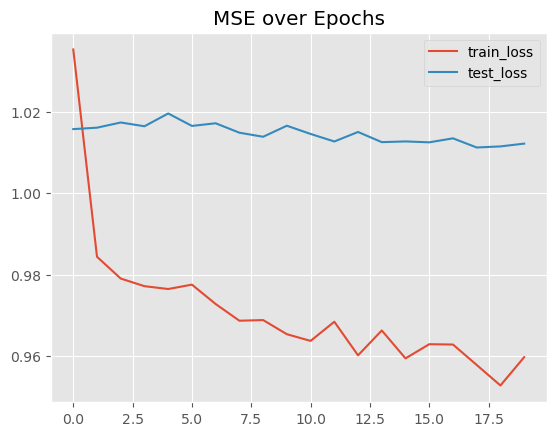

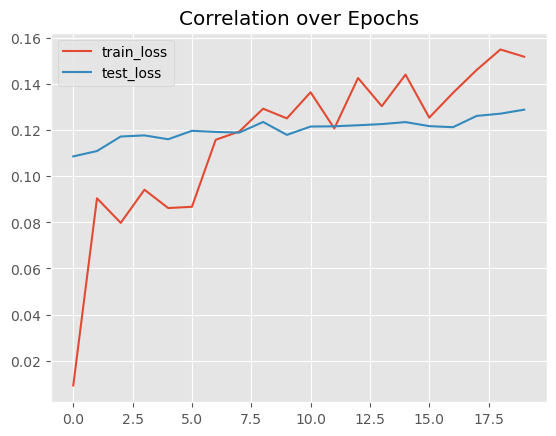

In [235]:
model_torch.fit(z.train, test=z.test, epochs=20)

In [236]:
comp = benchmark_comparison.Comparator(models=[model_torch, lasso], model_names=['transformer', 'lasso'])

In [237]:
comp.correl(z, mode='train')

,true,optimal,linear,conditional,shift,cs,cs_shift,transformer
optimal,0.164,nan,nan,nan,nan,nan,nan,nan
linear,0.095,0.500,nan,nan,nan,nan,nan,nan
conditional,0.056,0.417,0.013,nan,nan,nan,nan,nan
shift,0.065,0.472,0.005,-0.011,nan,nan,nan,nan
cs,0.073,0.463,0.012,0.018,0.009,nan,nan,nan
cs_shift,0.085,0.431,0.025,0.019,0.014,0.014,nan,nan
transformer,0.180,0.478,0.624,0.104,0.262,0.008,0.034,nan
lasso,0.121,0.360,0.713,0.019,0.004,0.004,0.022,0.819


In [238]:
comp.correl(z, mode='test')

,true,optimal,linear,conditional,shift,cs,cs_shift,transformer
optimal,0.154,nan,nan,nan,nan,nan,nan,nan
linear,0.075,0.507,nan,nan,nan,nan,nan,nan
conditional,0.053,0.407,0.016,nan,nan,nan,nan,nan
shift,0.093,0.462,-0.002,-0.017,nan,nan,nan,nan
cs,0.054,0.444,0.010,-0.009,-0.002,nan,nan,nan
cs_shift,0.069,0.427,0.034,0.014,0.002,-0.009,nan,nan
transformer,0.125,0.471,0.618,0.082,0.284,0.007,0.008,nan
lasso,0.119,0.370,0.722,-0.002,0.025,0.012,0.014,0.829


## Torch benchmarks - wide matrix (cross-TS interactions)

### Fully connected

In [239]:
z.get_dataloader()

In [240]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_ts, n_f):
        super().__init__()
        self.flatten = nn.Flatten()
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(n_ts*n_f, 512),
        #     nn.ReLU(),
        #     # nn.Linear(512, 512),
        #     # nn.ReLU(),
        #     nn.Linear(512, n_ts),
        # )
        
        self.linear_relu_stack = nn.Sequential(nn.Linear(n_ts*n_f, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, n_ts)
                                              )

    def forward(self, x):
        x = self.flatten(x)
        pred = self.linear_relu_stack(x)
        return pred

In [241]:
m = NeuralNetwork(n_ts=Config.n_ts, n_f=Config.n_f).to(device)
# optimizer = torch.optim.Adam(m.parameters(), lr=1e-3)#, weight_decay=1e-2)
optimizer = torch.optim.AdamW(m.parameters(), lr=5e-2, weight_decay=1e-2)
optimizer = torch.optim.SGD(m.parameters(), lr=2e-3)#AdamW(m.parameters(), lr=1e-3, weight_decay=1e-2)


full_nn = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.42it/s]


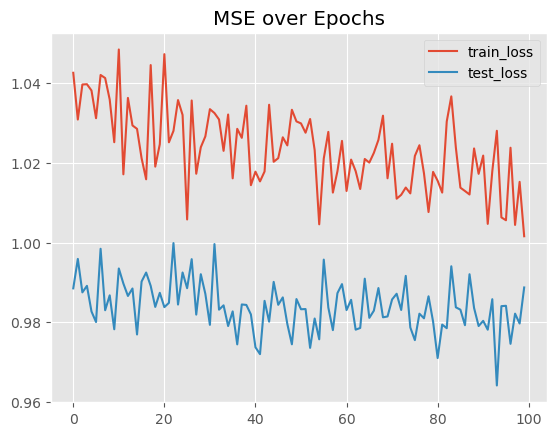

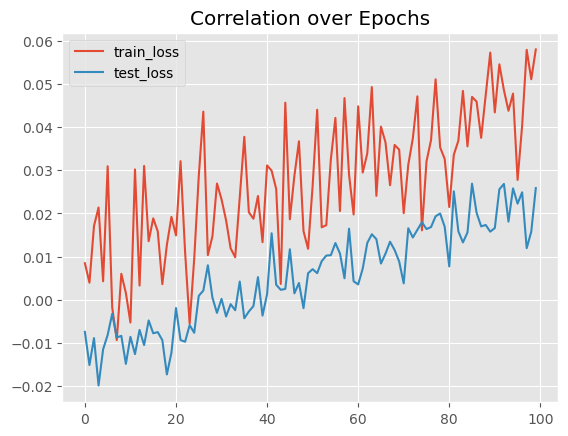

In [242]:
full_nn.fit(z.train, z.test, epochs=100)

In [243]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, full_nn], model_names=['lasso', 'lr', 'nn'])

In [244]:
comp.correl(z, mode='train')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr
optimal,0.164,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.089,0.509,nan,nan,nan,nan,nan,nan,nan
conditional,0.061,0.423,0.031,nan,nan,nan,nan,nan,nan
shift,0.078,0.468,0.004,-0.009,nan,nan,nan,nan,nan
cs,0.067,0.454,0.009,0.013,0.004,nan,nan,nan,nan
cs_shift,0.078,0.429,0.036,0.013,0.010,0.007,nan,nan,nan
lasso,0.126,0.370,0.716,0.027,0.013,0.007,0.023,nan,nan
lr,0.126,0.368,0.711,0.027,0.013,0.007,0.023,1.000,nan
nn,0.126,0.102,0.174,0.017,0.005,0.025,-0.002,0.296,0.297


In [245]:
comp.correl(z, mode='test')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr
optimal,0.154,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.088,0.485,nan,nan,nan,nan,nan,nan,nan
conditional,0.043,0.391,-0.027,nan,nan,nan,nan,nan,nan
shift,0.063,0.471,-0.000,-0.023,nan,nan,nan,nan,nan
cs,0.067,0.466,0.018,0.004,0.009,nan,nan,nan,nan
cs_shift,0.084,0.431,0.009,0.026,0.011,0.006,nan,nan,nan
lasso,0.107,0.346,0.714,-0.021,0.005,0.006,0.010,nan,nan
lr,0.106,0.343,0.708,-0.021,0.005,0.006,0.010,1.000,nan
nn,0.023,0.076,0.153,-0.010,0.013,0.010,-0.012,0.264,0.265


### LSTM model with 10 timestamps

In [246]:
z.get_dataloader(n_rolling=10, batch_size=1024)

In [247]:
from torch import nn
device = 'mps'

class LSTMModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, hidden_dim=128):
        super().__init__()
        self.encoder = nn.LSTM(input_size=n_ts*n_f, hidden_size=hidden_dim, batch_first=True)
        self.decoder = nn.Linear(hidden_dim, n_ts)
    
    def forward(self, x):
        # warning: lstm dimension needs to be flattened:
        # x: (batch, T=10, n_ts*n_f)
        _, (h, _) = self.encoder(x.reshape(x.shape[0], x.shape[1], x.shape[2] * x.shape[3]))
        out = self.decoder(h[-1]) 
        return out

In [248]:
m = LSTMModel(n_ts=Config.n_ts, n_f=Config.n_f, n_rolling=10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_lstm = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.42it/s]


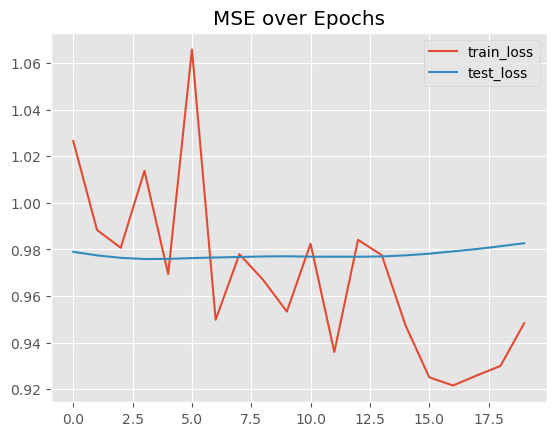

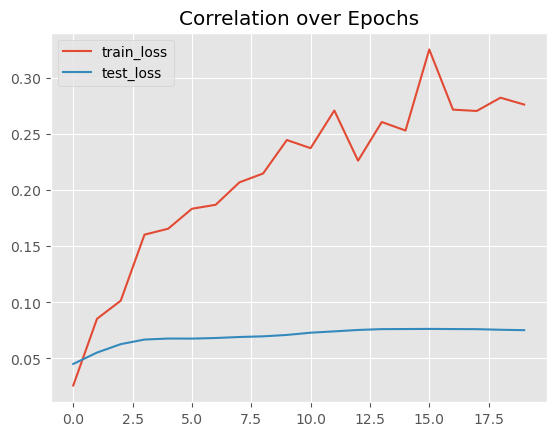

In [249]:
model_lstm.fit(z.train, test=z.test, epochs=20)

In [250]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm], model_names=['lasso', 'lr', 'lstm'])

In [251]:
comp.correl(z, mode='train')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr
optimal,0.164,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.089,0.509,nan,nan,nan,nan,nan,nan,nan
conditional,0.061,0.423,0.031,nan,nan,nan,nan,nan,nan
shift,0.078,0.468,0.004,-0.009,nan,nan,nan,nan,nan
cs,0.067,0.454,0.009,0.013,0.004,nan,nan,nan,nan
cs_shift,0.078,0.429,0.036,0.013,0.010,0.007,nan,nan,nan
lasso,0.126,0.370,0.716,0.027,0.013,0.007,0.023,nan,nan
lr,0.126,0.368,0.711,0.027,0.013,0.007,0.023,1.000,nan
lstm,0.289,0.254,0.282,0.023,0.115,0.118,0.012,0.383,0.384


In [252]:
comp.correl(z, mode='test')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr
optimal,0.154,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.088,0.485,nan,nan,nan,nan,nan,nan,nan
conditional,0.043,0.391,-0.027,nan,nan,nan,nan,nan,nan
shift,0.063,0.471,-0.000,-0.023,nan,nan,nan,nan,nan
cs,0.067,0.466,0.018,0.004,0.009,nan,nan,nan,nan
cs_shift,0.084,0.431,0.009,0.026,0.011,0.006,nan,nan,nan
lasso,0.107,0.346,0.714,-0.021,0.005,0.006,0.010,nan,nan
lr,0.106,0.343,0.708,-0.021,0.005,0.006,0.010,1.000,nan
lstm,0.075,0.240,0.285,-0.021,0.133,0.132,-0.030,0.386,0.386


### Transformer

In [253]:
z.get_dataloader(n_rolling=10)

In [254]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, d_model=128, nhead=8, num_layers=2, dropout=0.5):
        super().__init__()
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        # pass through Transformer encoder
        causal_mask = torch.triu(torch.ones(n_rolling, n_rolling, device=x.device), diagonal=1).bool()
        encoded = self.encoder(x, mask=causal_mask)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

In [255]:
def custom_loss(a, b):
    return 1 - torch.corrcoef(a, b)

In [256]:
m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, dropout=0.5).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


# model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, loss_fn=nn.L1Loss())
model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, loss_fn=nn.HuberLoss())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.56it/s]


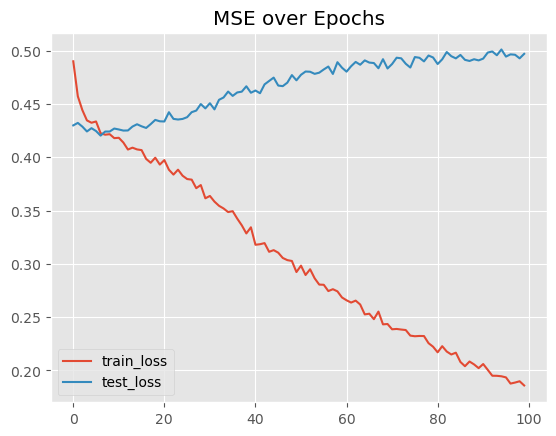

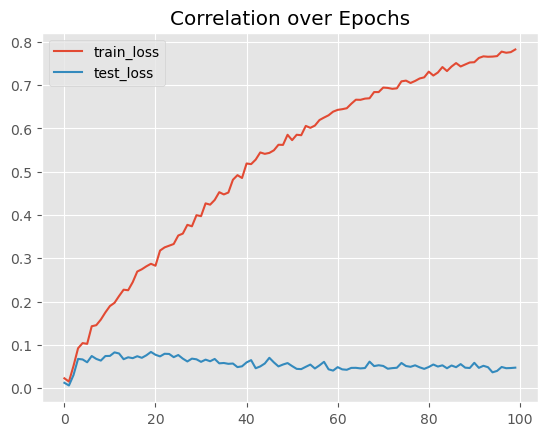

In [257]:
model_torch.fit(z.train, test=z.test, epochs=100)

In [258]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_torch], model_names=['lasso', 'lr', 'transformer'])

In [259]:
comp.correl(z, mode='train')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr
optimal,0.164,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.089,0.509,nan,nan,nan,nan,nan,nan,nan
conditional,0.061,0.423,0.031,nan,nan,nan,nan,nan,nan
shift,0.078,0.468,0.004,-0.009,nan,nan,nan,nan,nan
cs,0.067,0.454,0.009,0.013,0.004,nan,nan,nan,nan
cs_shift,0.078,0.429,0.036,0.013,0.010,0.007,nan,nan,nan
lasso,0.126,0.370,0.716,0.027,0.013,0.007,0.023,nan,nan
lr,0.126,0.368,0.711,0.027,0.013,0.007,0.023,1.000,nan
transformer,0.927,0.206,0.133,0.062,0.088,0.099,0.085,0.181,0.181


In [260]:
comp.correl(z, mode='test')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr
optimal,0.154,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.088,0.485,nan,nan,nan,nan,nan,nan,nan
conditional,0.043,0.391,-0.027,nan,nan,nan,nan,nan,nan
shift,0.063,0.471,-0.000,-0.023,nan,nan,nan,nan,nan
cs,0.067,0.466,0.018,0.004,0.009,nan,nan,nan,nan
cs_shift,0.084,0.431,0.009,0.026,0.011,0.006,nan,nan,nan
lasso,0.107,0.346,0.714,-0.021,0.005,0.006,0.010,nan,nan
lr,0.106,0.343,0.708,-0.021,0.005,0.006,0.010,1.000,nan
transformer,0.050,0.236,0.223,-0.020,0.047,0.191,0.068,0.296,0.296


### Re-writing the transformer and checking that we get the same results

In [261]:
z.get_dataloader(n_rolling=5)

In [262]:
def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx

# def causal_mask(b, h, q_idx, kv_idx):
#     return (q_idx == kv_idx) | (q_idx == 4) & (kv_idx == 3)

def plot_mask(mask_fn, seq_len=20, title=None, device="cpu"):
    """
    Plot a binary attention mask defined by mask_fn(b,h,q_idx,kv_idx)
    as a (seq_len x seq_len) matrix.
    """
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device) 
    h = torch.zeros(1, device=device)

    mask = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])
    mask = mask.float().cpu()

    return pd.DataFrame(mask).style.background_gradient(axis=None).format(precision=0)

def build_attention_mask(mask_fn, seq_len, device="cpu"):
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device)
    h = torch.zeros(1, device=device)
    mask_bool = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])  # (seq_len, seq_len)
    return mask_bool


In [263]:
mask_fn = causal_mask
plot_mask(mask_fn, seq_len=5)

,0,1,2,3,4
0,1,0,0,0,0
1,1,1,0,0,0
2,1,1,1,0,0
3,1,1,1,1,0
4,1,1,1,1,1


In [264]:
from torch.nn.attention.flex_attention import BlockMask, _mask_mod_signature, and_masks, or_masks


class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, mask, mask_=None, d_model=128, nhead=8, num_layers=2, dropout=0.5):
        super().__init__()
        self.mask = mask
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = transformers.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward = 4 * d_model,
            dropout=dropout,
        )
        self.encoder = transformers.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )
        
        self.decoder = nn.Sequential(
            # nn.LayerNorm(d_model),
            # nn.Linear(d_model, d_model),
            # nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(d_model, n_ts),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(n_ts, n_ts)
        )
        

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        encoded = self.encoder(x, mask=self.mask)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

In [265]:
mask = causal_mask
mask = build_attention_mask(mask, 5, device=device)

m = TransformerEncoderModel(Config.n_ts, Config.n_f, 5, mask=mask, dropout=0.5).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.10it/s]


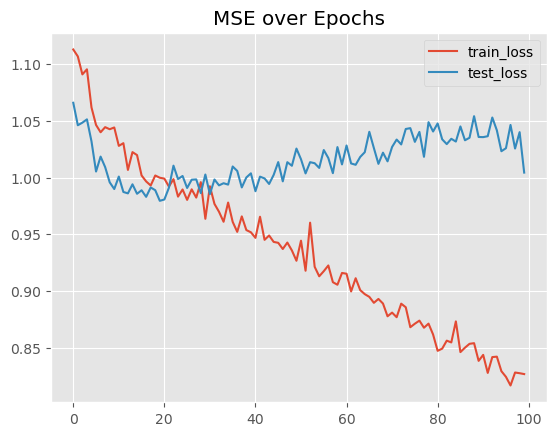

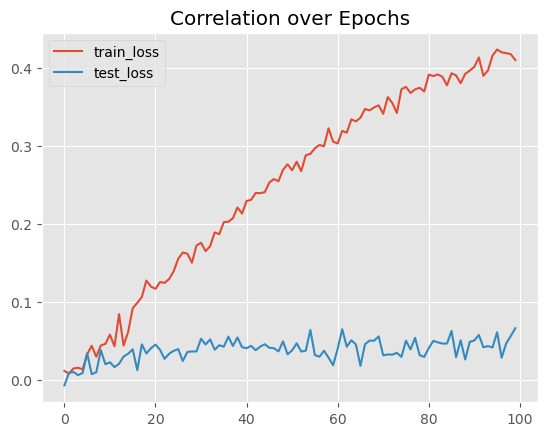

In [266]:
model_torch.fit(z.train, test=z.test, epochs=100)

In [267]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_torch], model_names=['lasso', 'lr', 'transformer'])

In [268]:
comp.correl(z, mode='train')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr
optimal,0.164,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.089,0.509,nan,nan,nan,nan,nan,nan,nan
conditional,0.061,0.423,0.031,nan,nan,nan,nan,nan,nan
shift,0.078,0.468,0.004,-0.009,nan,nan,nan,nan,nan
cs,0.067,0.454,0.009,0.013,0.004,nan,nan,nan,nan
cs_shift,0.078,0.429,0.036,0.013,0.010,0.007,nan,nan,nan
lasso,0.126,0.370,0.716,0.027,0.013,0.007,0.023,nan,nan
lr,0.126,0.368,0.711,0.027,0.013,0.007,0.023,1.000,nan
transformer,0.545,0.171,0.113,0.046,0.062,0.092,0.075,0.149,0.149


In [269]:
comp.correl(z, mode='test')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr
optimal,0.154,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.088,0.485,nan,nan,nan,nan,nan,nan,nan
conditional,0.043,0.391,-0.027,nan,nan,nan,nan,nan,nan
shift,0.063,0.471,-0.000,-0.023,nan,nan,nan,nan,nan
cs,0.067,0.466,0.018,0.004,0.009,nan,nan,nan,nan
cs_shift,0.084,0.431,0.009,0.026,0.011,0.006,nan,nan,nan
lasso,0.107,0.346,0.714,-0.021,0.005,0.006,0.010,nan,nan
lr,0.106,0.343,0.708,-0.021,0.005,0.006,0.010,1.000,nan
transformer,0.049,0.151,0.134,-0.007,0.040,0.105,0.056,0.181,0.181


### Example of attention deterministic sparsity

In [307]:
z.get_dataloader(n_rolling=10)

##### Rolling mask

In [308]:
def generate_sliding_window(window_size: int) -> _mask_mod_signature:
    def sliding_window(b, h, q_idx, kv_idx):
        return q_idx - kv_idx <= window_size

    sliding_window_mask = and_masks(sliding_window, causal_mask)
    sliding_window_mask.__name__ = f"sliding_window_{window_size}"
    return sliding_window_mask



mask_fn = generate_sliding_window(window_size=2)
plot_mask(mask_fn, seq_len=10)

,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0
3,0,1,1,1,0,0,0,0,0,0
4,0,0,1,1,1,0,0,0,0,0
5,0,0,0,1,1,1,0,0,0,0
6,0,0,0,0,1,1,1,0,0,0
7,0,0,0,0,0,1,1,1,0,0
8,0,0,0,0,0,0,1,1,1,0
9,0,0,0,0,0,0,0,1,1,1


In [309]:
mask = generate_sliding_window(2)
mask = build_attention_mask(mask, 10, device=device)
m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.16it/s]


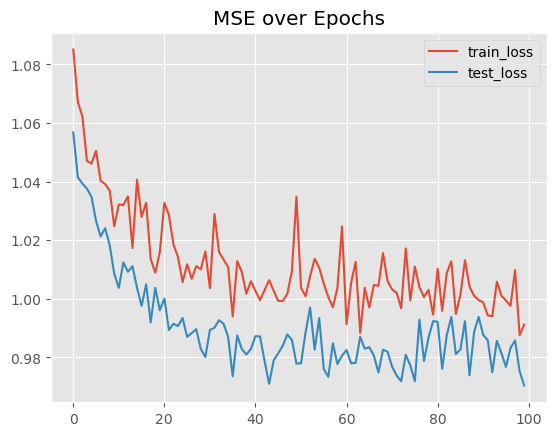

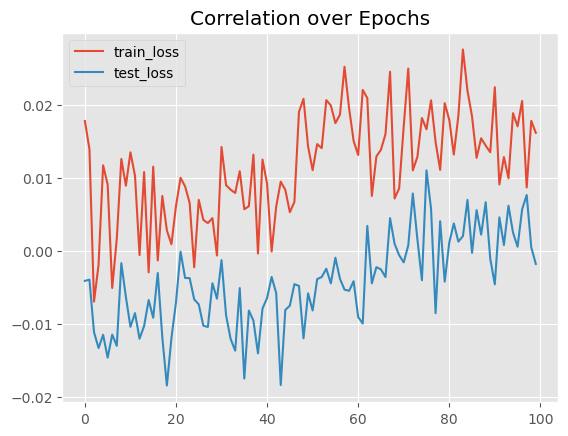

In [310]:
model_torch.fit(z.train, test=z.test, epochs=100)

In [311]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm, model_torch], model_names=['lasso', 'lr', 'lstm', 'transformer'])

In [312]:
comp.correl(z, mode='train')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr,lstm
optimal,0.164,nan,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.089,0.509,nan,nan,nan,nan,nan,nan,nan,nan
conditional,0.061,0.423,0.031,nan,nan,nan,nan,nan,nan,nan
shift,0.078,0.468,0.004,-0.009,nan,nan,nan,nan,nan,nan
cs,0.067,0.454,0.009,0.013,0.004,nan,nan,nan,nan,nan
cs_shift,0.078,0.429,0.036,0.013,0.010,0.007,nan,nan,nan,nan
lasso,0.126,0.370,0.716,0.027,0.013,0.007,0.023,nan,nan,nan
lr,0.126,0.368,0.711,0.027,0.013,0.007,0.023,1.000,nan,nan
lstm,0.289,0.254,0.282,0.023,0.115,0.118,0.012,0.383,0.384,nan
transformer,0.017,0.002,0.006,-0.000,-0.002,0.003,-0.003,0.013,0.013,0.136


In [313]:
comp.correl(z, mode='test')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr,lstm
optimal,0.154,nan,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.088,0.485,nan,nan,nan,nan,nan,nan,nan,nan
conditional,0.043,0.391,-0.027,nan,nan,nan,nan,nan,nan,nan
shift,0.063,0.471,-0.000,-0.023,nan,nan,nan,nan,nan,nan
cs,0.067,0.466,0.018,0.004,0.009,nan,nan,nan,nan,nan
cs_shift,0.084,0.431,0.009,0.026,0.011,0.006,nan,nan,nan,nan
lasso,0.107,0.346,0.714,-0.021,0.005,0.006,0.010,nan,nan,nan
lr,0.106,0.343,0.708,-0.021,0.005,0.006,0.010,1.000,nan,nan
lstm,0.075,0.240,0.285,-0.021,0.133,0.132,-0.030,0.386,0.386,nan
transformer,0.002,-0.007,-0.007,0.004,0.016,-0.032,0.005,-0.028,-0.027,0.085


##### Dilation mask

In [314]:
def generate_dilated(dilation: int) -> _mask_mod_signature:
    def dilated_sliding_window(b, h, q_idx, kv_idx):
        diff = torch.abs(q_idx - kv_idx)
        is_dilated = (diff % dilation) == 0
        # is_dilated = diff == 0
        return is_dilated
    
    dilated_sliding_window_mask = and_masks(causal_mask, dilated_sliding_window)
    dilated_sliding_window_mask.__name__ = f"dilation_{dilation}"
    return dilated_sliding_window_mask

mask_fn = generate_dilated(3)
plot_mask(mask_fn, seq_len=10)

,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0
4,0,1,0,0,1,0,0,0,0,0
5,0,0,1,0,0,1,0,0,0,0
6,1,0,0,1,0,0,1,0,0,0
7,0,1,0,0,1,0,0,1,0,0
8,0,0,1,0,0,1,0,0,1,0
9,1,0,0,1,0,0,1,0,0,1


In [315]:
mask = generate_dilated(dilation=3)
mask = build_attention_mask(mask, 10, device=device)
m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.81it/s]


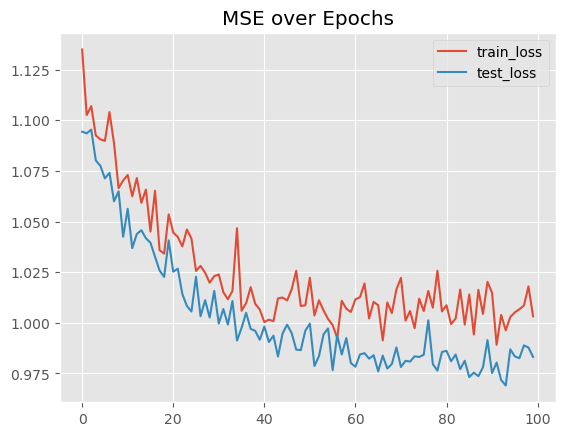

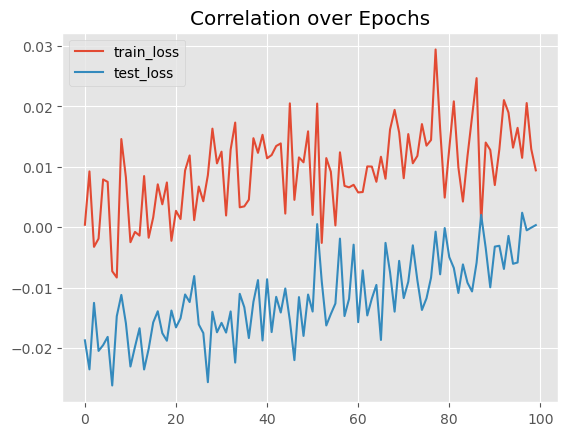

In [316]:
model_torch.fit(z.train, test=z.test, epochs=100)

In [317]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm, model_torch], model_names=['lasso', 'lr', 'lstm', 'transformer'])

In [318]:
comp.correl(z, mode='train')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr,lstm
optimal,0.164,nan,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.089,0.509,nan,nan,nan,nan,nan,nan,nan,nan
conditional,0.061,0.423,0.031,nan,nan,nan,nan,nan,nan,nan
shift,0.078,0.468,0.004,-0.009,nan,nan,nan,nan,nan,nan
cs,0.067,0.454,0.009,0.013,0.004,nan,nan,nan,nan,nan
cs_shift,0.078,0.429,0.036,0.013,0.010,0.007,nan,nan,nan,nan
lasso,0.126,0.370,0.716,0.027,0.013,0.007,0.023,nan,nan,nan
lr,0.126,0.368,0.711,0.027,0.013,0.007,0.023,1.000,nan,nan
lstm,0.289,0.254,0.282,0.023,0.115,0.118,0.012,0.383,0.384,nan
transformer,0.016,-0.000,0.005,-0.001,-0.001,0.000,-0.005,0.013,0.013,0.134


In [319]:
comp.correl(z, mode='test')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr,lstm
optimal,0.154,nan,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.088,0.485,nan,nan,nan,nan,nan,nan,nan,nan
conditional,0.043,0.391,-0.027,nan,nan,nan,nan,nan,nan,nan
shift,0.063,0.471,-0.000,-0.023,nan,nan,nan,nan,nan,nan
cs,0.067,0.466,0.018,0.004,0.009,nan,nan,nan,nan,nan
cs_shift,0.084,0.431,0.009,0.026,0.011,0.006,nan,nan,nan,nan
lasso,0.107,0.346,0.714,-0.021,0.005,0.006,0.010,nan,nan,nan
lr,0.106,0.343,0.708,-0.021,0.005,0.006,0.010,1.000,nan,nan
lstm,0.075,0.240,0.285,-0.021,0.133,0.132,-0.030,0.386,0.386,nan
transformer,0.001,-0.008,-0.009,0.004,0.017,-0.033,0.003,-0.028,-0.028,0.084


##### Dilation mask combined with rolling

In [320]:
def dilation_rolling(dilation: int, window: int) -> _mask_mod_signature:
    return or_masks(generate_dilated(dilation), generate_sliding_window(window))

mask_fn = dilation_rolling(dilation=3, window=3)
plot_mask(mask_fn, seq_len=10)

,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,0
4,0,1,1,1,1,0,0,0,0,0
5,0,0,1,1,1,1,0,0,0,0
6,1,0,0,1,1,1,1,0,0,0
7,0,1,0,0,1,1,1,1,0,0
8,0,0,1,0,0,1,1,1,1,0
9,1,0,0,1,0,0,1,1,1,1


In [321]:
mask = dilation_rolling(dilation=3, window=2)
mask = build_attention_mask(mask, 10, device=device)
m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.59it/s]


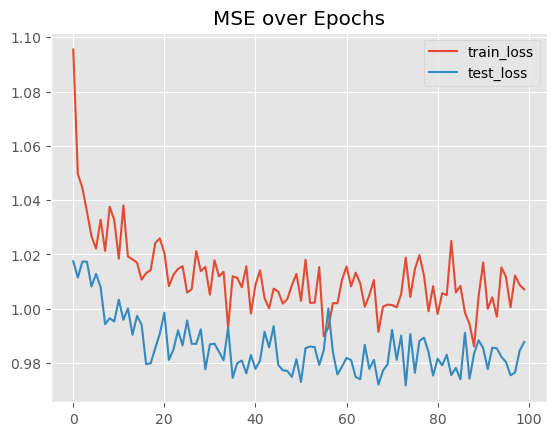

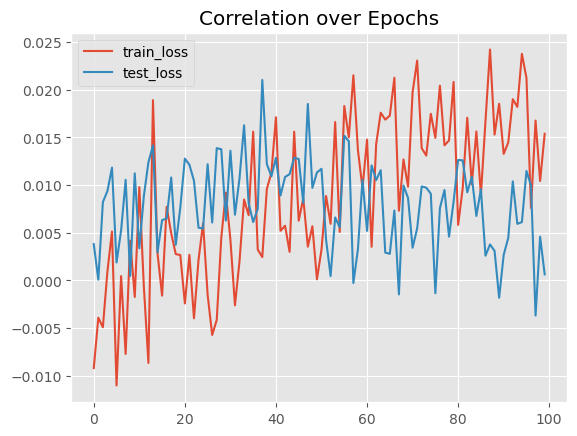

In [322]:
model_torch.fit(z.train, test=z.test, epochs=100)

In [323]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm, model_torch], model_names=['lasso', 'lr', 'lstm', 'transformer'])

In [324]:
comp.correl(z, mode='train')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr,lstm
optimal,0.164,nan,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.089,0.509,nan,nan,nan,nan,nan,nan,nan,nan
conditional,0.061,0.423,0.031,nan,nan,nan,nan,nan,nan,nan
shift,0.078,0.468,0.004,-0.009,nan,nan,nan,nan,nan,nan
cs,0.067,0.454,0.009,0.013,0.004,nan,nan,nan,nan,nan
cs_shift,0.078,0.429,0.036,0.013,0.010,0.007,nan,nan,nan,nan
lasso,0.126,0.370,0.716,0.027,0.013,0.007,0.023,nan,nan,nan
lr,0.126,0.368,0.711,0.027,0.013,0.007,0.023,1.000,nan,nan
lstm,0.289,0.254,0.282,0.023,0.115,0.118,0.012,0.383,0.384,nan
transformer,0.017,0.002,0.006,0.001,-0.003,0.003,-0.004,0.013,0.013,0.135


In [325]:
comp.correl(z, mode='test')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr,lstm
optimal,0.154,nan,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.088,0.485,nan,nan,nan,nan,nan,nan,nan,nan
conditional,0.043,0.391,-0.027,nan,nan,nan,nan,nan,nan,nan
shift,0.063,0.471,-0.000,-0.023,nan,nan,nan,nan,nan,nan
cs,0.067,0.466,0.018,0.004,0.009,nan,nan,nan,nan,nan
cs_shift,0.084,0.431,0.009,0.026,0.011,0.006,nan,nan,nan,nan
lasso,0.107,0.346,0.714,-0.021,0.005,0.006,0.010,nan,nan,nan
lr,0.106,0.343,0.708,-0.021,0.005,0.006,0.010,1.000,nan,nan
lstm,0.075,0.240,0.285,-0.021,0.133,0.132,-0.030,0.386,0.386,nan
transformer,0.004,-0.007,-0.009,0.004,0.016,-0.030,0.003,-0.027,-0.027,0.085


## Sparse Attention

In [289]:
z.get_dataloader(n_rolling=10)

In [290]:
def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx

# def causal_mask(b, h, q_idx, kv_idx):
#     return q_idx >= (kv_idx+100)

def plot_mask(mask_fn, seq_len=20, title=None, device="cpu"):
    """
    Plot a binary attention mask defined by mask_fn(b,h,q_idx,kv_idx)
    as a (seq_len x seq_len) matrix.
    """
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device) 
    h = torch.zeros(1, device=device)

    mask = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])
    mask = mask.float().cpu()

    return pd.DataFrame(mask).style.background_gradient(axis=None).format(precision=0)

def build_attention_mask(mask_fn, seq_len, device="cpu"):
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device)
    h = torch.zeros(1, device=device)
    mask_bool = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])  # (seq_len, seq_len)
    return mask_bool


In [291]:
mask_fn = causal_mask
plot_mask(mask_fn, seq_len=5)

,0,1,2,3,4
0,1,0,0,0,0
1,1,1,0,0,0
2,1,1,1,0,0
3,1,1,1,1,0
4,1,1,1,1,1


In [292]:
from torch.nn.attention.flex_attention import BlockMask, _mask_mod_signature, and_masks, or_masks


class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, mask, mask_=None, d_model=128, nhead=8, num_layers=2, dropout=0.5, attn_l1_coeff=0, sparsify=None):
        super().__init__()
        self.mask = mask
        self.sparsify = sparsify
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = transformers.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward = 4 * d_model,
            dropout=dropout,
        )
        self.encoder = transformers.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )
        
        self.decoder = nn.Sequential(
            # nn.LayerNorm(d_model),
            # nn.Linear(d_model, d_model),
            # nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(d_model, n_ts),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(n_ts, n_ts)
        )
        

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        encoded = self.encoder(x, mask=self.mask, sparsify=self.sparsify)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

In [293]:
mask = causal_mask
mask = build_attention_mask(mask, 10, device=device)
def custom_mask_mod(b, h, q_idx, kv_idx):
    return mask[q_idx, kv_idx]

m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=None).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=0.001)


model_causal = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.10it/s]


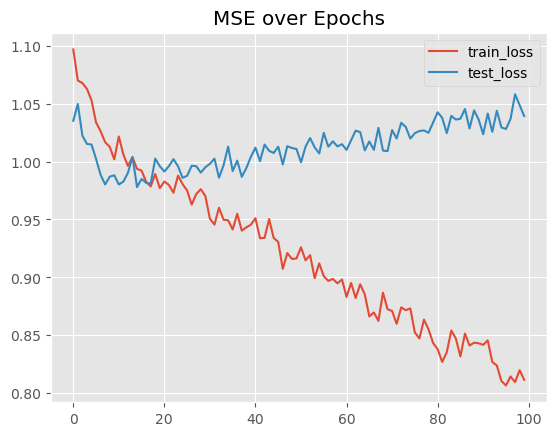

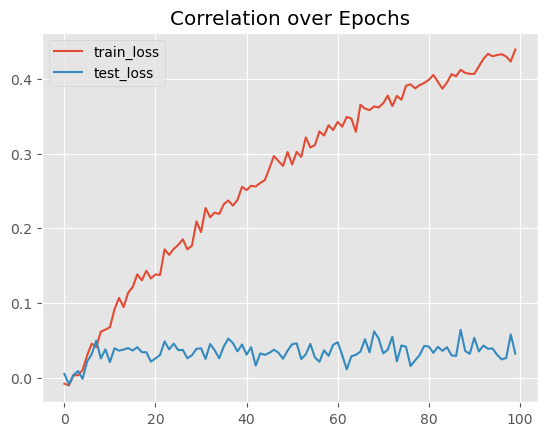

In [294]:
model_causal.fit(z.train, test=z.test, epochs=100)

In [301]:
# Function used to make the attention matrix sparse

def keep_topk_per_row(x, k=2):
    vals, idx = torch.topk(x, k=k, dim=-1, largest=True)
    out = torch.zeros_like(x)
    out.scatter_(-1, idx, 1)
    return out

In [302]:
mask = causal_mask
mask = build_attention_mask(mask, 10, device=device)
def custom_mask_mod(b, h, q_idx, kv_idx):
    return mask[q_idx, kv_idx]

m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=0.001)


model_sparse = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:55<00:00,  7.19it/s]


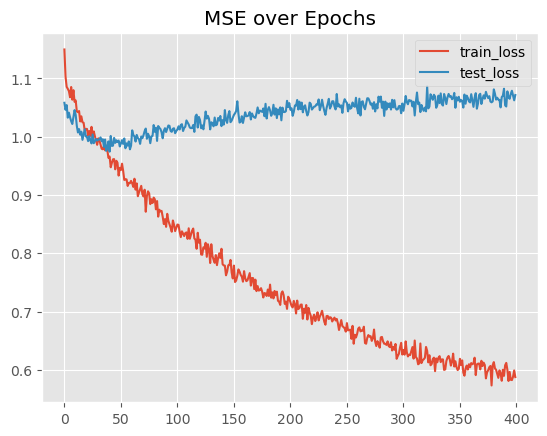

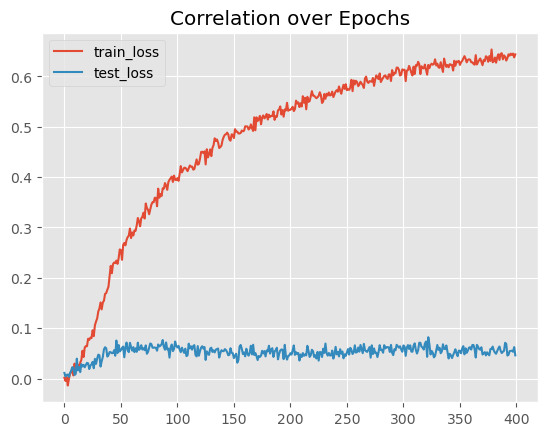

In [303]:
model_sparse.fit(z.train, test=z.test, epochs=400)

In [304]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_causal, model_sparse], model_names=['lasso', 'lr', 'causal', 'sparse'])

In [305]:
comp.correl(z, mode='train')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr,causal
optimal,0.164,nan,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.089,0.509,nan,nan,nan,nan,nan,nan,nan,nan
conditional,0.061,0.423,0.031,nan,nan,nan,nan,nan,nan,nan
shift,0.078,0.468,0.004,-0.009,nan,nan,nan,nan,nan,nan
cs,0.067,0.454,0.009,0.013,0.004,nan,nan,nan,nan,nan
cs_shift,0.078,0.429,0.036,0.013,0.010,0.007,nan,nan,nan,nan
lasso,0.126,0.370,0.716,0.027,0.013,0.007,0.023,nan,nan,nan
lr,0.126,0.368,0.711,0.027,0.013,0.007,0.023,1.000,nan,nan
causal,0.545,0.147,0.098,0.024,0.042,0.103,0.065,0.161,0.162,nan
sparse,0.846,0.194,0.125,0.063,0.082,0.094,0.076,0.170,0.170,0.537


In [306]:
comp.correl(z, mode='test')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr,causal
optimal,0.154,nan,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.088,0.485,nan,nan,nan,nan,nan,nan,nan,nan
conditional,0.043,0.391,-0.027,nan,nan,nan,nan,nan,nan,nan
shift,0.063,0.471,-0.000,-0.023,nan,nan,nan,nan,nan,nan
cs,0.067,0.466,0.018,0.004,0.009,nan,nan,nan,nan,nan
cs_shift,0.084,0.431,0.009,0.026,0.011,0.006,nan,nan,nan,nan
lasso,0.107,0.346,0.714,-0.021,0.005,0.006,0.010,nan,nan,nan
lr,0.106,0.343,0.708,-0.021,0.005,0.006,0.010,1.000,nan,nan
causal,0.043,0.122,0.097,-0.026,0.029,0.126,0.037,0.220,0.221,nan
sparse,0.052,0.186,0.193,-0.021,0.041,0.154,0.031,0.252,0.251,0.259


## DRAFT - Modifying the attention matrix sparsity

#### Attention Gym examples

In [73]:
import torch
from attn_gym.utils import cdiv
from torch.nn.attention.flex_attention import BlockMask, _mask_mod_signature, and_masks, or_masks



def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx


def create_causal_block_mask_fast(
    batch_size: int | None,
    num_heads: int | None,
    q_seq_len: int,
    kv_seq_len: int,
    device: torch.device,
    block_size: int = 128,
    separate_full_blocks: bool = True,
) -> BlockMask:
    """Create a causal block mask efficiently without materializing the full mask.

    This function generates the block mask data structure directly for causal attention,
    avoiding the need to create and process a full dense mask. This is much more efficient
    for long sequences.

    Args:
        q_seq_len: Query sequence length
        kv_seq_len: Key/value sequence length
        device: Device to create tensors on
        batch_size: Batch size (defaults to 1 if None)
        num_heads: Number of attention heads (defaults to 1 if None)
        block_size: Block size for the block mask (both Q and KV use same size)
        separate_full_blocks: Whether to separate full blocks from partial blocks

    Returns:
        BlockMask: Block mask object for causal attention
    """
    if batch_size is None:
        batch_size = 1
    if num_heads is None:
        num_heads = 1
    if isinstance(block_size, tuple):
        q_block_size, kv_block_size = block_size
    else:
        q_block_size = kv_block_size = block_size

    num_q_blocks = cdiv(q_seq_len, q_block_size)
    num_kv_blocks = cdiv(kv_seq_len, kv_block_size)

    # For causal mask, each query block can attend to all KV blocks up to and including
    # the diagonal block
    kv_num_blocks = torch.zeros(
        (batch_size, num_heads, num_q_blocks), dtype=torch.int32, device=device
    )
    kv_indices = torch.zeros(
        (batch_size, num_heads, num_q_blocks, num_kv_blocks), dtype=torch.int32, device=device
    )

    if separate_full_blocks:
        full_kv_num_blocks = torch.zeros(
            (batch_size, num_heads, num_q_blocks), dtype=torch.int32, device=device
        )
        full_kv_indices = torch.zeros(
            (batch_size, num_heads, num_q_blocks, num_kv_blocks), dtype=torch.int32, device=device
        )
    else:
        full_kv_num_blocks = None
        full_kv_indices = None

    for q_block_idx in range(num_q_blocks):
        # For causal attention, query block i can attend to KV blocks [0, i]
        # The last block in the diagonal may be partial
        num_full_blocks = min(q_block_idx, num_kv_blocks)
        num_partial_blocks = 1 if q_block_idx < num_kv_blocks else 0

        if separate_full_blocks:
            assert full_kv_num_blocks is not None
            assert full_kv_indices is not None

            if num_partial_blocks > 0:
                min_q_index = q_block_idx * q_block_size
                max_kv_index = min((q_block_idx + 1) * kv_block_size - 1, kv_seq_len - 1)
                is_diagonal_full = min_q_index >= max_kv_index
            else:
                is_diagonal_full = False

            if is_diagonal_full:
                # Diagonal block is full - move it from partial to full
                full_kv_num_blocks[:, :, q_block_idx] = num_full_blocks + 1
                kv_num_blocks[:, :, q_block_idx] = 0  # No partial blocks

                # Set indices for all full blocks (including diagonal)
                indices = torch.arange(num_full_blocks + 1, device=device)
                full_kv_indices[:, :, q_block_idx, : num_full_blocks + 1] = indices
            else:
                # Diagonal block is partial (or doesn't exist)
                full_kv_num_blocks[:, :, q_block_idx] = num_full_blocks
                kv_num_blocks[:, :, q_block_idx] = num_partial_blocks

                # Set indices for full blocks
                if num_full_blocks > 0:
                    indices = torch.arange(num_full_blocks, device=device)
                    full_kv_indices[:, :, q_block_idx, :num_full_blocks] = indices

                # Set index for partial block
                if num_partial_blocks > 0:
                    kv_indices[:, :, q_block_idx, 0] = q_block_idx
        else:
            # All blocks go into partial
            total_blocks = num_full_blocks + num_partial_blocks
            kv_num_blocks[:, :, q_block_idx] = total_blocks
            if total_blocks > 0:
                indices = torch.arange(total_blocks, device=device)
                kv_indices[:, :, q_block_idx, :total_blocks] = indices

    return BlockMask.from_kv_blocks(
        kv_num_blocks=kv_num_blocks,
        kv_indices=kv_indices,
        full_kv_num_blocks=full_kv_num_blocks,
        full_kv_indices=full_kv_indices,
        BLOCK_SIZE=(q_block_size, kv_block_size),
        mask_mod=causal_mask,
        seq_lengths=(q_seq_len, kv_seq_len),
    )

def generate_sliding_window(window_size: int) -> _mask_mod_signature:
    """Generates a sliding window attention mask with a given window size.
    Args:
        window_size: The size of the sliding window.

    Note:
        We assume that the window size represents the lookback size and we mask out all future tokens
        similar to causal masking.
    """

    def sliding_window(b, h, q_idx, kv_idx):
        return q_idx - kv_idx <= window_size

    sliding_window_mask = and_masks(sliding_window, causal_mask)
    sliding_window_mask.__name__ = f"sliding_window_{window_size}"
    return sliding_window_mask


def generate_dilated_sliding_window(window_size: int, dilation: int) -> _mask_mod_signature:
    """Generates a dilated sliding window attention mask.
    Args:
        window_size: The size of the sliding window.
        dilation: The dilation factor for the sliding window.

    Note:
        Query at position i can only attend to keys within a window of size `window_size`
        centered around i, where the keys are at positions j such that:
        * abs(i - j) <= window_size
        * abs(i - j) % dilation == 0
    """

    def dilated_sliding_window(b, h, q_idx, kv_idx):
        diff = torch.abs(q_idx - kv_idx)
        in_window = diff <= window_size
        is_dilated = (diff % dilation) == 0
        return in_window & is_dilated
    
    dilated_sliding_window_mask = and_masks(causal_mask, dilated_sliding_window)
    dilated_sliding_window_mask.__name__ = f"dilated_sliding_window_{window_size}_dilation_{dilation}"
    return dilated_sliding_window_mask


"""Visualize the attention scores of causal masking.

Args:
    device (str): Device to use for computation. Defaults
"""
import torch
from attn_gym import visualize_attention_scores

B, H, SEQ_LEN, HEAD_DIM = 1, 1, 12, 1

def make_tensor():
    return torch.ones(B, H, SEQ_LEN, HEAD_DIM, device=device)

query, key = make_tensor(), make_tensor()

visualize_attention_scores(query, key, mask_mod=causal_mask, device=device, name="causal_mask")
mask = generate_sliding_window(3)
visualize_attention_scores(query, key, mask_mod=mask, device=device, name="sliding_mask")
mask = generate_dilated_sliding_window(6, 3)
visualize_attention_scores(query, key, mask_mod=mask, device=device, name="dilated_mask")

Visualization saved as causal_mask.png
Visualization saved as sliding_mask.png
Visualization saved as dilated_mask.png
